## Importing the required libraries

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras_preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

In [2]:
from keras import regularizers

In [3]:
import os

In [78]:
mylist= os.listdir('DataSets/')

In [5]:
type(mylist)

list

In [6]:
print(mylist[350])

03-01-03-01-02-01-15.wav


In [7]:

print(mylist[300][6:-16])

03


## Plotting the audio file's waveform and its spectrogram

In [79]:
data, sampling_rate = librosa.load('DataSets/03-01-01-01-01-01-05.wav')

In [83]:
% pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)


UsageError: Line magic function `%` not found.


C:\Users\user\AppData\Local\Temp\ipykernel_24836\998798181.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr,x = scipy.io.wavfile.read('RawData/03-01-01-01-01-01-05.wav')


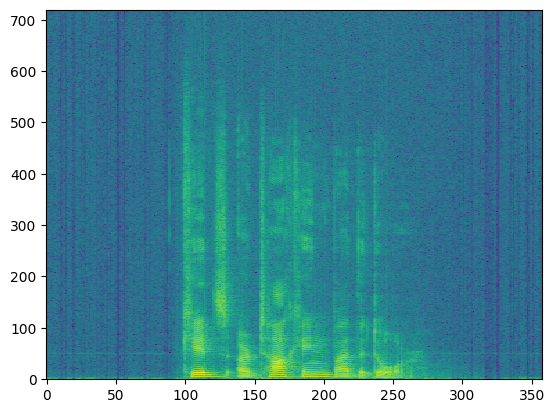

In [10]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys

sr,x = scipy.io.wavfile.read('DataSets/03-01-01-01-01-01-05.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

## Setting the labels

In [11]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
    elif item[:1]=='a':
        feeling_list.append('male_angry')
    elif item[:1]=='f':
        feeling_list.append('male_fearful')
    elif item[:1]=='h':
        feeling_list.append('male_happy')
    #elif item[:1]=='n':
        #feeling_list.append('neutral')
    elif item[:2]=='sa':
        feeling_list.append('male_sad')

In [15]:
import pandas as pd
labels = pd.DataFrame(feeling_list)


In [16]:
labels[:10]

,0
0,male_calm
1,female_calm
2,male_calm
3,female_calm
4,male_calm
5,female_calm
6,male_calm
7,female_calm
8,male_calm
9,female_calm


## Getting the features of audio files using librosa

In [17]:

df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        X, sample_rate = librosa.load('DataSets/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1        

In [18]:
df[:5]

,feature
0,"[-70.26808, -70.26808, -70.26808, -70.26808, -..."
1,"[-65.707375, -65.707375, -63.11476, -61.5191, ..."
2,"[-65.48282, -65.48282, -65.48282, -65.48282, -..."
3,"[-64.52863, -64.52863, -64.52863, -64.52863, -..."
4,"[-63.64624, -59.995125, -61.87015, -67.49628, ..."


In [19]:
df3 = pd.DataFrame(df['feature'].values.tolist())

df3[:5]

In [20]:
newdf = pd.concat([df3,labels], axis=1)

In [21]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [22]:
rnewdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,...,-57.447964,-58.897030,-58.751503,-57.406185,-60.078960,-63.427284,-62.639057,-61.242519,-61.356304,male_calm
1,-65.707375,-65.707375,-63.114761,-61.519100,-61.097507,-63.424744,-63.720127,-56.854958,-55.169304,-54.640343,...,-39.792603,-40.614014,-41.209988,-41.439613,-43.994671,-49.399967,-50.591972,-49.112217,-48.155739,female_calm
2,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,-65.482819,...,-31.348970,-34.310616,-35.803104,-35.938644,-37.633038,-40.119911,-41.663399,-41.552986,-41.974155,male_calm
3,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-64.528633,-65.928391,...,-48.674786,-48.596626,-47.603218,-43.049660,-42.660038,-43.189026,-44.001690,-43.328537,-42.985413,female_calm
4,-63.646240,-59.995125,-61.870152,-67.496277,-71.072220,-65.680321,-63.394951,-65.503853,-61.858971,-60.007896,...,-39.072914,-41.896790,-40.866905,-38.293262,-36.375126,-37.914906,-40.027390,-43.315861,-44.848808,male_calm


In [23]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
391,-56.155685,-53.556431,-54.674721,-55.003654,-54.083061,-53.164509,-52.789299,-53.055996,-53.992859,-57.787231,...,-39.149193,-39.213936,-36.982128,-36.559433,-37.286129,-38.087124,-39.468254,-38.988491,-40.887253,female_sad
283,-65.935341,-65.935341,-65.935341,-65.935341,-65.935341,-65.935341,-65.935341,-65.935341,-65.935341,-65.935341,...,-63.968567,-62.206020,-63.054043,-63.765118,-62.634346,-63.911396,-64.808060,-62.796185,-64.057495,female_happy
889,-50.249943,-50.249943,-50.249943,-50.255623,-50.314640,-50.416019,-50.496723,-50.364815,-49.938950,-48.833031,...,-47.588310,-47.472328,-48.161846,-48.074585,-47.586605,-47.317875,-47.287457,-46.981876,-47.917213,female_fearful
790,-59.781147,-59.781147,-59.781147,-59.781147,-59.781147,-59.781147,-59.781147,-59.781147,-59.781147,-59.781147,...,-55.317497,-57.339809,-56.979370,-53.937107,-53.569889,-55.386082,-56.995972,-56.050270,-58.182861,male_fearful
602,-54.583866,-54.052597,-54.273861,-54.376179,-54.604164,-54.307030,-53.649837,-53.730648,-53.717232,-53.512932,...,-24.440788,-24.727360,-26.746878,-26.880999,-26.606190,-26.658878,-25.823812,-24.855591,-26.848543,male_angry
453,-60.941299,-57.337685,-55.661003,-55.990810,-57.889526,-57.380276,-56.131271,-55.972435,-56.685493,-54.990669,...,-49.886429,-50.502998,-51.093369,-50.915459,-51.974068,-51.381645,-52.028671,-52.877232,-54.888920,female_sad
808,-42.355465,-45.357620,-47.184441,-47.208878,-47.210632,-48.556351,-48.161842,-48.230366,-48.932987,-48.314865,...,-45.140339,-46.201641,-44.978432,-45.091702,-44.487202,-44.011681,-45.555954,-44.429478,-39.662109,male_fearful
208,-59.411312,-55.203163,-54.076267,-51.710976,-51.416679,-53.840508,-53.147991,-52.481529,-54.422367,-54.124046,...,-52.204643,-51.386456,-51.909225,-53.564278,-52.205002,-50.530869,-51.548843,-53.456314,-54.090012,male_happy
794,-54.872124,-54.471821,-54.633587,-55.004646,-54.126160,-53.985344,-54.347843,-54.995316,-56.836205,-56.798885,...,-21.382336,-21.050615,-22.935282,-25.554020,-27.868876,-29.028694,-29.760176,-30.858215,-34.074471,male_fearful
631,-46.732361,-49.312744,-49.537437,-49.165421,-49.961143,-49.895359,-50.056770,-47.998741,-49.212368,-51.043392,...,-51.971897,-51.041733,-49.913734,-51.230835,-52.506653,-50.665615,-49.479832,-50.189903,-51.853901,female_angry


In [24]:
rnewdf=rnewdf.fillna(0)

## Dividing the data into test and train

In [25]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [26]:
train[250:260]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
852,-59.340008,-59.262947,-60.366257,-58.971298,-55.639023,-52.754604,-50.809433,-49.738911,-48.262779,-48.855286,...,-57.850456,-61.591129,-59.090614,-58.086914,-58.123013,-57.531387,-57.785603,-58.698513,-60.127739,male_fearful
50,-67.100395,-65.226883,-64.960434,-63.794121,-63.573341,-64.165131,-65.601288,-66.433060,-66.506744,-65.544037,...,-25.323580,-29.268787,-32.811779,-34.223553,-34.462486,-36.663773,-36.138676,-36.805340,-37.903179,male_calm
566,-52.919449,-52.854530,-51.134995,-50.964951,-54.616447,-52.937416,-51.824715,-53.824924,-54.257488,-52.662472,...,-34.755302,-34.238396,-36.066551,-34.063122,-33.520248,-35.777897,-37.551598,-30.034874,-24.081429,male_sad
404,-65.925941,-61.223953,-59.245083,-61.108421,-61.599522,-59.919853,-62.103642,-65.501617,-60.370735,-56.122452,...,-23.298725,-23.449938,-23.634884,-23.264914,-25.469133,-24.622746,-26.568176,-29.725433,-31.798321,male_sad
295,-47.846672,-49.249695,-48.507744,-48.846802,-49.324848,-50.057487,-49.539894,-47.900105,-48.293736,-48.275288,...,-43.127937,-44.854588,-47.850750,-44.638878,-44.379967,-46.842651,-47.953995,-47.142452,-46.466450,female_happy
31,-58.494282,-56.043633,-55.715603,-53.285862,-54.063011,-55.382912,-56.325535,-54.312721,-54.464890,-55.783890,...,-54.917732,-58.299679,-55.335995,-52.633476,-53.408493,-54.989681,-52.086758,-52.173862,-50.941319,female_calm
448,-52.862045,-50.297615,-49.708420,-53.008198,-52.668404,-52.429222,-52.042072,-50.351303,-49.606514,-48.956863,...,-52.824993,-53.651161,-54.524235,-54.553589,-55.576653,-54.387352,-51.498161,-52.745888,-55.972370,male_sad
837,-50.184448,-51.785484,-52.150356,-53.196358,-53.348957,-52.534847,-51.635521,-50.806339,-50.000298,-50.401611,...,-49.674423,-48.065422,-48.738621,-52.110832,-53.139622,-53.866192,-51.623421,-51.500179,-53.680183,female_fearful
718,-45.079384,-45.079384,-45.079384,-45.079384,-45.079384,-45.079384,-45.079384,-45.079384,-45.079384,-45.079384,...,-43.588032,-42.803501,-42.723484,-43.573750,-44.581154,-45.079384,-43.456455,-42.601650,-42.604046,male_angry
311,-55.767189,-55.767189,-55.767189,-55.767189,-55.767189,-55.767189,-55.767189,-55.767189,-55.767189,-55.767189,...,-36.567734,-36.726189,-38.104557,-38.821571,-38.295574,-36.559822,-36.244907,-36.376240,-35.483524,female_happy


In [27]:
trainfeatures = train.iloc[:, :-1]

In [28]:
trainlabel = train.iloc[:, -1:]

In [29]:
testfeatures = test.iloc[:, :-1]

In [30]:
testlabel = test.iloc[:, -1:]

In [35]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [36]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [37]:
X_train.shape


(771, 216)

## Changing dimension for CNN model

In [38]:

x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [40]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('Softmax'))
opt = keras.optimizers.RMSprop(learning_rate=0.00001)

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 216, 256)          1536      
                                                                 
 activation_5 (Activation)   (None, 216, 256)          0         
                                                                 
 conv1d_5 (Conv1D)           (None, 216, 128)          163968    
                                                                 
 activation_6 (Activation)   (None, 216, 128)          0         
                                                                 
 dropout_1 (Dropout)         (None, 216, 128)          0         
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 27, 128)           0         
 g1D)                                                            
                                                      

In [42]:

model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

### Removed the whole training part for avoiding unnecessary long epochs list

In [44]:

cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=50, validation_data=(x_testcnn, y_test))

Epoch 1/50
49/49 [==============================] - 5s 104ms/step - loss: 1.8361 - accuracy: 0.3424 - val_loss: 1.8715 - val_accuracy: 0.2804
Epoch 2/50
49/49 [==============================] - 5s 96ms/step - loss: 1.8208 - accuracy: 0.3528 - val_loss: 1.8238 - val_accuracy: 0.3333
Epoch 3/50
49/49 [==============================] - 5s 93ms/step - loss: 1.8044 - accuracy: 0.3671 - val_loss: 1.8273 - val_accuracy: 0.3386
Epoch 4/50
49/49 [==============================] - 4s 91ms/step - loss: 1.8039 - accuracy: 0.3541 - val_loss: 1.8083 - val_accuracy: 0.3492
Epoch 5/50
49/49 [==============================] - 4s 92ms/step - loss: 1.7925 - accuracy: 0.3709 - val_loss: 1.7881 - val_accuracy: 0.3228
Epoch 6/50
49/49 [==============================] - 4s 91ms/step - loss: 1.7802 - accuracy: 0.3852 - val_loss: 1.7897 - val_accuracy: 0.3862
Epoch 7/50
49/49 [==============================] - 5s 93ms/step - loss: 1.7716 - accuracy: 0.3684 - val_loss: 1.7796 - val_accuracy: 0.3228
Epoch 8/50
4

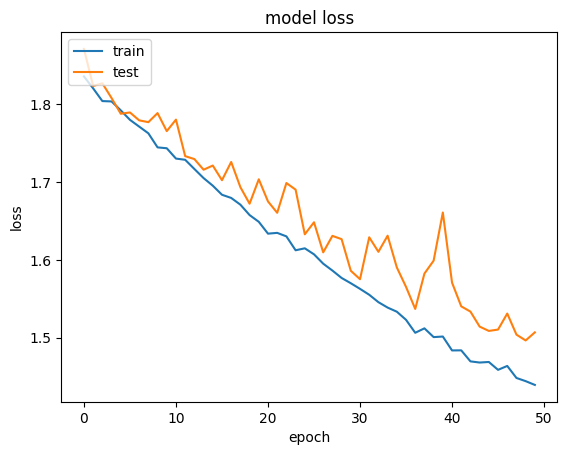

In [45]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [46]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved trained model at f:\Speech-Emotion-Analyzer-master_without_rawdata\Speech-Emotion-Analyzer-master\saved_models\Emotion_Voice_Detection_Model.h5 


In [47]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [48]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 42.33%


## Predicting emotions on the test data

In [49]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

6/6 [==============================] - 1s 47ms/step


In [50]:
preds

array([[0.10372852, 0.25427467, 0.14846036, ..., 0.00226536, 0.00494103,
        0.01057354],
       [0.0829917 , 0.03209908, 0.22258973, ..., 0.00329928, 0.00191745,
        0.00198599],
       [0.00353619, 0.01759634, 0.00483754, ..., 0.11251708, 0.21376349,
        0.12000064],
       ...,
       [0.33855832, 0.04367914, 0.196619  , ..., 0.01111708, 0.01097085,
        0.00532544],
       [0.00405905, 0.00559072, 0.00193093, ..., 0.15876786, 0.12384523,
        0.11103505],
       [0.01172924, 0.01966886, 0.00049808, ..., 0.10477575, 0.17072672,
        0.12332546]], dtype=float32)

In [51]:
preds1=preds.argmax(axis=1)

In [52]:
preds1

array([4, 4, 6, 4, 6, 4, 6, 6, 5, 6, 4, 4, 5, 6, 6, 8, 1, 6, 4, 8, 4, 7,
       6, 4, 4, 7, 4, 2, 2, 4, 3, 0, 2, 5, 5, 1, 6, 4, 5, 2, 4, 5, 5, 5,
       2, 7, 0, 2, 2, 4, 6, 4, 6, 4, 6, 4, 3, 4, 6, 6, 2, 4, 8, 1, 6, 7,
       4, 9, 4, 4, 6, 0, 2, 6, 4, 6, 2, 1, 6, 7, 4, 4, 4, 3, 6, 8, 4, 1,
       4, 4, 8, 4, 5, 8, 0, 2, 5, 6, 6, 6, 2, 4, 4, 6, 1, 5, 4, 2, 1, 0,
       8, 7, 7, 2, 4, 6, 4, 1, 4, 0, 6, 4, 7, 4, 5, 8, 4, 4, 4, 4, 5, 4,
       5, 5, 0, 2, 0, 4, 6, 6, 1, 6, 6, 0, 2, 5, 5, 4, 6, 5, 6, 9, 5, 0,
       2, 6, 4, 4, 2, 5, 6, 5, 4, 6, 6, 5, 4, 1, 6, 6, 6, 7, 6, 6, 6, 6,
       6, 6, 1, 7, 4, 4, 4, 5, 6, 4, 0, 6, 6], dtype=int64)

In [53]:
abc = preds1.astype(int).flatten()

In [54]:
predictions = (lb.inverse_transform((abc)))

In [55]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,female_sad
1,female_sad
2,male_calm
3,female_sad
4,male_calm
5,female_sad
6,male_calm
7,male_calm
8,male_angry
9,male_calm


In [56]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [57]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,female_sad
1,female_fearful
2,male_fearful
3,female_sad
4,male_sad
5,female_calm
6,male_calm
7,male_calm
8,male_angry
9,male_calm


In [58]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [59]:
finaldf[170:180]

,actualvalues,predictedvalues
170,male_calm,male_calm
171,male_fearful,male_fearful
172,male_happy,male_calm
173,male_happy,male_calm
174,male_happy,male_calm
175,female_calm,male_calm
176,male_fearful,male_calm
177,male_calm,male_calm
178,female_calm,female_calm
179,male_fearful,male_fearful


In [60]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,24
female_calm,21
female_fearful,13
female_happy,19
female_sad,18
male_angry,20
male_calm,21
male_fearful,16
male_happy,22


In [61]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,11
female_calm,11
female_fearful,18
female_happy,3
female_sad,54
male_angry,23
male_calm,49
male_fearful,10
male_happy,8


In [62]:
finaldf.to_csv('Predictions.csv', index=False)

## Live Demo

#### The file 'output10.wav' in the next cell is the file that was recorded live using the code in AudioRecoreder notebook found in the repository

In [65]:
data, sampling_rate = librosa.load('output10.wav')

In [67]:
% pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

UsageError: Line magic function `%` not found.


In [68]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('output.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [69]:
livedf2= pd.DataFrame(data=livedf2)

In [70]:
livedf2 = livedf2.stack().to_frame().T

In [71]:
livedf2

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-27.599758,-24.682961,-24.521282,-23.60955,-21.891603,-21.617008,-20.314512,-16.567518,-15.962356,-17.249172,...,-23.776623,-23.618864,-24.413425,-25.271549,-22.215597,-19.955837,-20.311729,-21.221851,-23.436403,-25.05233


In [72]:
twodim= np.expand_dims(livedf2, axis=2)

In [73]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 72ms/step


In [74]:
livepreds

array([[0.16862154, 0.04375874, 0.3585304 , 0.09424619, 0.283134  ,
        0.00204962, 0.00333866, 0.0199177 , 0.0106467 , 0.01575635]],
      dtype=float32)

In [75]:
livepreds1=livepreds.argmax(axis=1)

In [76]:
liveabc = livepreds1.astype(int).flatten()

In [77]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions

array(['female_fearful'], dtype=object)